In [1]:
# ! pip install wordcloud
# !pip install spacy pandas seaborn matplotlib nltk

In [39]:
import os
import re
import json
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
import string
from collections import Counter
from wordcloud import WordCloud

import spacy
from spacy import displacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex
from spacy.matcher import Matcher
from spacy.tokens import Span

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/tiagolima/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tiagolima/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tiagolima/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
import sys
sys.path.append('../')
from config import entity_to_acronyms, acronyms_to_entities, colors

In [42]:
json_colors = colors

In [43]:
data_dir = '../data/bio_stanford_acm'

In [44]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir,  exist_ok=True, mode=0o777)

In [45]:
def get_doc_ids(data_dir):
    """
    Extracts unique document IDs from a directory of files.

    Args:
        data_dir (str): Path to the directory containing the files.

    Returns:
        list: A list of unique document IDs (strings) found in the directory.

    Raises:
        OSError: If the specified directory does not exist or cannot be accessed.
        ValueError: If no files with the expected naming convention are found in the directory.
    """
    if not os.path.exists(data_dir):
        raise OSError(f"Directory {data_dir} does not exist.")
    
    doc_ids = []
    for doc in os.listdir(data_dir):
        doc_id = doc.split(".")[0]
        if doc_id not in doc_ids and doc.endswith(("ann", "txt")):
            doc_ids.append(doc_id)

    if not doc_ids:
        raise ValueError(f"No files with expected naming convention found in {data_dir}.")
    
    return doc_ids


In [46]:
doc_ids = get_doc_ids(data_dir)
print(f"Number of documents is {len(doc_ids)}")
print(doc_ids)

Number of documents is 5250
['231382', '185869', '234433', '88335', '97267', '237615', '45890', '79456', '194316', '1314', '163653', '193443', '276570', '230947', '66318', '130623', '141499', '272370', '48443', '95195', '13993', '108563', '5688', '47439', '6566', '159088', '95330', '232920', '68234', '152746', '143780', '185002', '284112', '119672', '161292', '255863', '155833', '258776', '18757', '76627', '51126', '64581', '76689', '104965', '60670', '87303', '10427', '233881', '221977', '54291', '16987', '79348', '156331', '84349', '283231', '55868', '193568', '27529', '148009', '197243', '146113', '165522', '108232', '146507', '260139', '184940', '85093', '99129', '89498', '87706', '94166', '95855', '169440', '10406', '212812', '244398', '12212', '193408', '103837', '190606', '12886', '70309', '225189', '95075', '142416', '103007', '282639', '58440', '63894', '187116', '234434', '111601', '92788', '81382', '26253', '82796', '286524', '185701', '77168', '115468', '120194', '161785', 

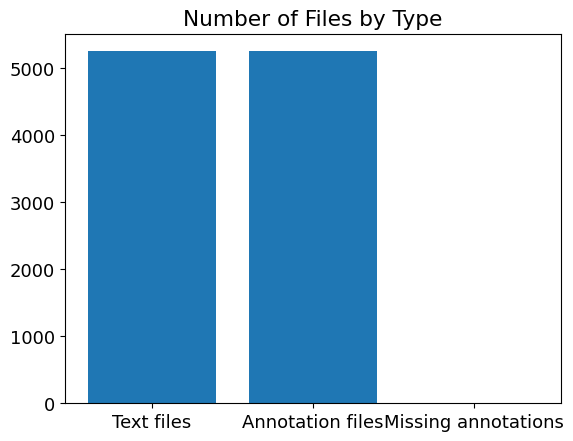

In [47]:
text_files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
ann_files = [f for f in os.listdir(data_dir) if f.endswith('.ann')]

text_ids = [f.split('.')[0] for f in text_files]
ann_ids = [f.split('.')[0] for f in ann_files]

# count number of files without annotations
missing_anns = 0
for text_id in text_ids:
    if text_id not in ann_ids:
        missing_anns += 1

# create bar chart
labels = ['Text files', 'Annotation files', 'Missing annotations']
counts = [len(text_files), len(ann_files), missing_anns]

plt.bar(labels, counts)
plt.title('Number of Files by Type')
plt.show()

In [48]:
def load_txt_data(txt_dir, doc_ids):
    """
    Loads text data from a directory of .txt files into a dictionary.

    Args:
        txt_dir: Path to the directory containing the .txt files.
        doc_ids: A list of file IDs (strings) to load from the directory.

    Returns:
        A dictionary of file IDs (strings) mapped to their corresponding data, 
        where each data item is represented by a nested dictionary containing the following key-value pairs:
            - "text": the full text of the file as a string.
            - "annotations": an empty list to be used for annotations on the file.

    Raises:
        OSError: If the specified directory does not exist or cannot be accessed.
        ValueError: If no .txt files are found in the directory.
    """
    if not os.path.exists(txt_dir):
        raise OSError(f"Directory {txt_dir} does not exist.")

    data = {}
    
    for file_id in doc_ids:
        
        file_name = file_id + ".txt"
        
        with open(os.path.join(txt_dir, file_name), "r") as f:
            text = f.read()
            
        data[file_id] = {
                "text": text, 
                "annotations": []
        }

    if not data:
        raise ValueError(f"No .txt files found in {txt_dir}.")

    return data

In [49]:
data = load_txt_data(data_dir, doc_ids)
print("data: {")
for doc_id in list(data.keys())[:3]:
    print(f"\t'{doc_id}': {{")
    text = data[doc_id]['text']
    annotations = data[doc_id]['annotations']
    print(f"\t\ttext:\t{text[:3]} .....")
    print(f"\t\tannotations: {annotations}")
    print("\t},")
print('\t....')
print("}")

data: {
	'231382': {
		text:	rec .....
		annotations: []
	},
	'185869': {
		text:	rec .....
		annotations: []
	},
	'234433': {
		text:	rn  .....
		annotations: []
	},
	....
}


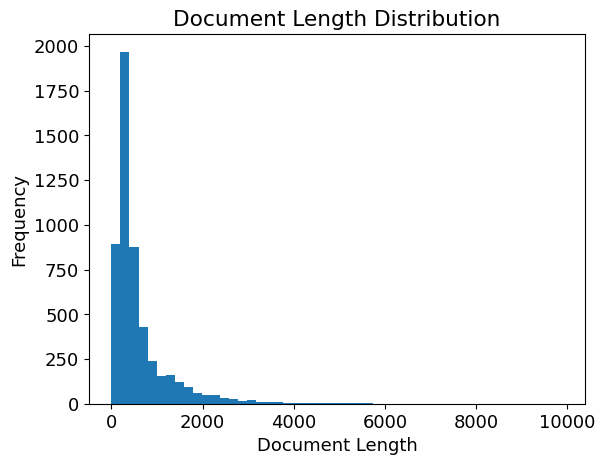

In [50]:
def get_doc_length_distribution(data):
    """
    Computes the document length distribution for a dictionary of documents.

    Args:
        data (dict): A dictionary where the keys are document IDs and the values are dictionaries
                     containing the 'text' field with the text of the document.

    Returns:
        list: A list of document lengths (integers).
    """
    
    doc_lengths = []
    for doc_id in data:
        
            text = data[doc_id]['text']
            
            doc_length = len(text)
            doc_lengths.append(doc_length)
    
    return doc_lengths


doc_lengths = get_doc_length_distribution(data)

# plot the document length distribution
plt.hist(doc_lengths, bins=50)
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.title("Document Length Distribution")
plt.show()

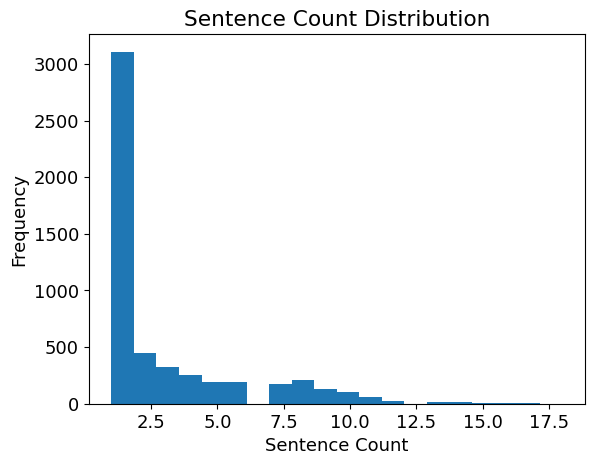

In [51]:
def get_doc_sentence_counts(data):
    """
    Computes the number of sentences in each document.

    Args:
        data (dict): A dictionary where the keys are document IDs and the values are dictionaries
                     containing the 'text' field with the text of the document.

    Returns:
        list: A list of sentence counts (integers) for each document.
    """
    
    sentence_counts = []
    for doc_id in data:
        text = data[doc_id]['text']
        sentences = nltk.sent_tokenize(text)
        sentence_count = len(sentences)
        sentence_counts.append(sentence_count)
    
    return sentence_counts

# get the sentence counts
sentence_counts = get_doc_sentence_counts(data)

# plot the sentence count distribution
plt.hist(sentence_counts, bins=20)
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")
plt.title("Sentence Count Distribution")
plt.show()

In [15]:
def get_word_frequency_distribution(data):
    """
    Computes the word frequency distribution for a dictionary of documents.

    Args:
        data (dict): A dictionary where the keys are document IDs and the values are dictionaries
                     containing the 'text' field with the text of the document.

    Returns:
        dict: A dictionary where the keys are words and the values are their frequency counts.
    """
    
    # Load stop words
    stop_words = set(stopwords.words('portuguese'))
    
    # Tokenize text and count word frequency
    all_words = []
    for doc_id in data:
        text = data[doc_id]['text']
        words = nltk.word_tokenize(text)
        words = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
        all_words.extend(words)
        
    word_freq = dict(Counter(all_words))
    
    return word_freq

def plot_word_freq_distribution(word_freq):
    """
    Plots the word frequency distribution.

    Args:
        word_freq (dict): A dictionary where the keys are words and the values are their frequency counts.
    """

    # sort the word frequencies in descending order
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    # extract the word and frequency lists from the sorted word frequency tuples
    words, freqs = zip(*sorted_word_freq)

    # plot the word frequency distribution
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(words)), freqs)

    plt.ylabel('Frequency')
    plt.title('Word Frequency Distribution')
    plt.show()



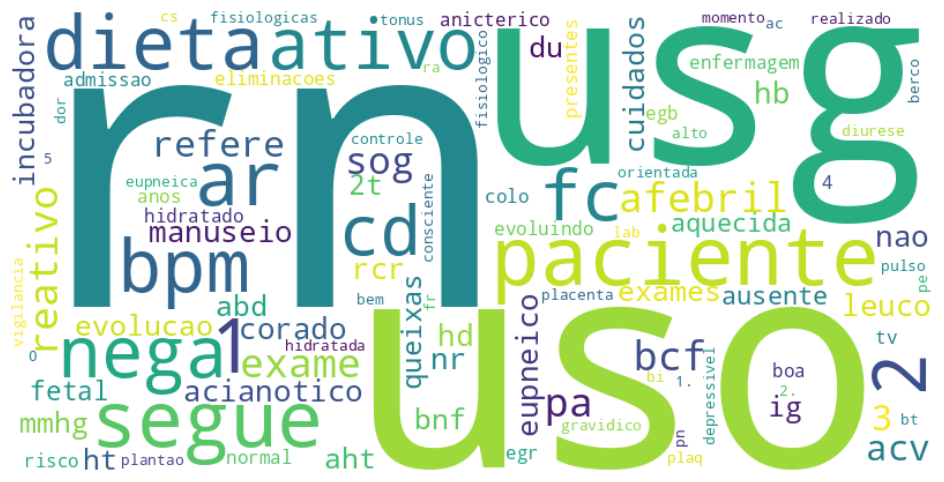

In [52]:

def get_word_frequencies(data):
    """
    Computes the word frequency distribution for a dictionary of documents.

    Args:
        data (dict): A dictionary where the keys are document IDs and the values are dictionaries
                     containing the 'text' field with the text of the document.

    Returns:
        FreqDist: A frequency distribution object from the nltk.probability module.
    """
    
    word_freq = FreqDist()
    stop_words = set(stopwords.words('portuguese'))
    for doc_id in data:
        text = data[doc_id]['text']
        tokens = word_tokenize(text)
        
        # Remove stopwords and punctuation
        clean_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token not in string.punctuation]
        
        # Update word frequency distribution
        word_freq.update(clean_tokens)
    
    return word_freq

def plot_wordcloud(word_freq):
    """
    Plots a wordcloud of the word frequency distribution.

    Args:
        word_freq (FreqDist): A frequency distribution object from the nltk.probability module.
    """
    
    wc = WordCloud(background_color='white', max_words=100, width=800, height=400)
    wc.generate_from_frequencies(word_freq)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
word_freq = get_word_frequencies(data)
plot_wordcloud(word_freq)

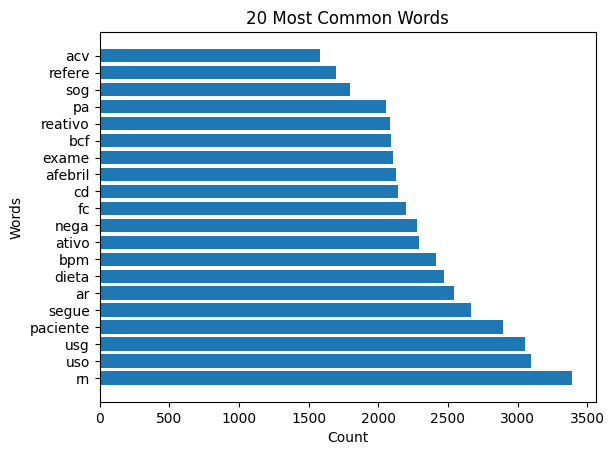

In [17]:
import matplotlib.pyplot as plt
from collections import Counter
import collections


stop_words = set(stopwords.words('portuguese'))

all_words = []
for doc_id in data:
    text = data[doc_id]['text']
    words = nltk.word_tokenize(text)
    words = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
    all_words.extend(words)
    
# Get the word frequency distribution
word_freq = Counter(all_words)
# Remove stop words
for stop_word in stop_words:
    del word_freq[stop_word]


# Get the 20 most common words
most_common = word_freq.most_common(20)

# Create a horizontal bar chart
words = [word[0] for word in most_common]
counts = [word[1] for word in most_common]
plt.barh(words, counts)

# Add labels and title
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("20 Most Common Words")

plt.show()

In [18]:
non_ascii_characters = []
# Loop through each file in the folder
for doc_id in doc_ids:
    # Check if the file is a .txt file
    filename = f"{doc_id}.txt"
    # Open the file
    with open(os.path.join(data_dir, filename), 'r', encoding='utf-8') as file:
        # Read the file content
        file_content = file.read()
        # Find all non-ASCII characters using regular expressions
        non_ascii_chars = re.findall(r'[^\x00-\x7F]', file_content)
        # Print the filename and the special characters found
        if non_ascii_chars: 
            print(f'File: {filename}, Non-ASCII characters: {non_ascii_chars}')        
        non_ascii_characters.extend(non_ascii_chars)

File: 141499.txt, Non-ASCII characters: ['°']
File: 143780.txt, Non-ASCII characters: ['°']
File: 119672.txt, Non-ASCII characters: ['°']
File: 023978.txt, Non-ASCII characters: ['°']
File: 065116.txt, Non-ASCII characters: ['°']
File: 275817.txt, Non-ASCII characters: ['°']
File: 072595.txt, Non-ASCII characters: ['°']
File: 105081.txt, Non-ASCII characters: ['°']
File: 111516.txt, Non-ASCII characters: ['°']
File: 076347.txt, Non-ASCII characters: ['°']
File: 117086.txt, Non-ASCII characters: ['°']
File: 012946.txt, Non-ASCII characters: ['°']
File: 107608.txt, Non-ASCII characters: ['°', '°']
File: 088616.txt, Non-ASCII characters: ['°']
File: 025183.txt, Non-ASCII characters: ['°']
File: 036749.txt, Non-ASCII characters: ['°']
File: 168631.txt, Non-ASCII characters: ['°']
File: 100305.txt, Non-ASCII characters: ['°']
File: 010259.txt, Non-ASCII characters: ['°']
File: 014073.txt, Non-ASCII characters: ['°']
File: 121189.txt, Non-ASCII characters: ['°']
File: 231160.txt, Non-ASCII c

In [19]:
from unidecode import unidecode

for char in set(non_ascii_characters):
    print(f"{char}  {unidecode(char)}")

°  deg


In [20]:
sample_ann_file = doc_id + ".ann"
lines = []
with open(os.path.join(data_dir, sample_ann_file)) as f:
    for line in f.readlines():
        lines.append(line)
print("")
for line in lines[:6]:
    print(line.strip())


S1	Session 0 319	evolution


In [21]:
tags = []

for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f.readlines():
            tags.append(line.split("\t")[0][0])
                
set(tags)

{'S'}

In [22]:
flag = False
for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f.readlines():
            if line.startswith('T'):
                label = line.split('\t')[1].split()[0]
                start_end_pair = line.split('\t')[1].split()[1:]
                if len(start_end_pair) > 2:
                    print('There exists more than one start end offset pairs')
                    print(' '.join(start_end_pair))


## Estudo SOAP do formulário

In [23]:
soap_list_entity = {}

for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    soap_dict = {}
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f:
            if line.startswith("S"):
                s, sss,x, y, category = line.split()

                if category in soap_dict.keys():
                    soap_dict[category].append((x, y))
                else:
                    soap_dict[category] = []
                    soap_dict[category].append((x, y))
                    
    # print(soap_dict)
    with open(os.path.join(data_dir, ann_file)) as f:         
        for line in f:
            if line.startswith('T'):
                
                _, entity_type, x, y = line.split()[:4]
                for category, item in soap_dict.items():
                    for (sx, sy) in item:
                        if x>= sx and y>=sx:
                            if not category in soap_list_entity.keys():
                                soap_list_entity[category] = {}
                            soap_list_entity[category][entity_type] = soap_list_entity[category].get(entity_type, 0) + 1

entity_types = list(soap_list_entity.keys())
counts = list(soap_list_entity.values())

# Agrupar os dados pelo primeiro key
grouped_data = {}
for category, subdict in soap_list_entity.items():
    for entity, count in subdict.items():
        if category not in grouped_data:
            grouped_data[category] = {}
        grouped_data[category][entity] = count

# Plotar os dados agrupados
fig, axes = plt.subplots(len(grouped_data), 1, figsize=(15, len(grouped_data) * 5))

if len(grouped_data) == 1:
    axes = [axes]

for ax, (category, subdict) in zip(axes, grouped_data.items()):
    entities = list(subdict.keys())
    counts = list(subdict.values())
    ax.bar(entities, counts)
    ax.set_title(f'Sesssion Counts in {category}')
    ax.set_xlabel('Entity')
    ax.set_ylabel('Count')
    ax.set_xticklabels(entities, rotation=90)

plt.tight_layout()
plt.show()



ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x0 with 0 Axes>

In [ ]:
# Função para ler o documento de texto
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

# Função para separar subtextos
def separate_subtexts(text, delimiter1, delimiter2):
    # Dividir o texto pelo primeiro delimitador
    parts = text.split(delimiter1)
    subtexts = []

    # Para cada parte, dividir pelo segundo delimitador
    for part in parts:
        sub_parts = part.split(delimiter2)
        subtexts.extend(sub_parts)

    # Remover subtextos vazios
    subtexts = [subtext.strip() for subtext in subtexts if subtext.strip()]
    return subtexts

In [ ]:
soap_list_entity = {}

soap_classifier_entity = {}

for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    soap_dict = {}
    ordened_lines = []
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f:
            if line.startswith("S"):
                s, sss,x, y, category = line.split()
                ordened_lines.append(category)

                if category in soap_dict.keys():
                    soap_dict[category].append((x, y))
                else:
                    soap_dict[category] = []
                    soap_dict[category].append((x, y))
                    
    txt_file = os.path.join(data_dir, doc_id + ".txt") 
    with open(txt_file) as f:
        sx, sy = 0,0
        for index, line in enumerate(f.readlines()):
            # print(line)
            category = ordened_lines[index]
            if not category in soap_classifier_entity.keys():
                soap_classifier_entity[category] = []
            soap_classifier_entity[category].append(line)
            
print(soap_classifier_entity)          

import json
with open('../soap_classifier_entity.json', 'w', encoding='utf-8') as f:
    json.dump(soap_classifier_entity, f, ensure_ascii=False, indent=None)
    


In [24]:
def splitting_tokens(file_id, start, end, hyphen_split=True):
    """
    Splits a token into its constituent words and returns a list of tokens along with the corresponding
    ranges for each word in the original text.

    Args:
        text (str): The original text containing the token to be split.
        start (int): The starting index of the token in the text.
        end (int): The ending index of the token in the text.

    Returns:
        A tuple containing:
            - a list of the constituent words of the token
            - a list of lists containing the start and end indices of each word in the original token
    """
    text = data[file_id]['text']
    token = text[start:end]

    extra_sep = ['\u200a']
    if hyphen_split:
        extra_sep += ['-', '\u2010', '\u2011', '\u2012', '\u2013', '\u2014', '\u2015', '\u2212', '\uff0d']

    new_range = []
    tokens = []

    curr = start
    new_start = None

    for c in token + " ":
        if c.isspace() or c in extra_sep:
            if new_start:
                new_range.append([new_start, curr])
                tokens.append(text[new_start:curr])
                new_start = None
        elif not new_start:
            new_start = curr
        curr += 1

    return tokens, new_range

In [25]:
def load_ann_data(ann_dir, doc_ids, data, hyphen_split=True):
    """
    Loads annotations from a directory of .ann files and adds them to the corresponding 
    files in a data dictionary.

    Args:
        ann_dir (str): Path to the directory containing the .ann files.
        data (dict): A dictionary of file IDs (strings) mapped to their corresponding data, 
        where each data item is represented by a nested dictionary containing the following key-value pairs:
            - "text": the full text of the file as a string.
            - "annotations": a list of annotations for the file, where each annotation is represented 
            by a dictionary containing the following key-value pairs:
                - "label": the label of the annotation as a string.
                - "start": the starting character index of the annotation as an integer.
                - "end": the ending character index of the annotation as an integer.

    Returns:
        data - modified the input dictionary
    """
    for doc_id in doc_ids:

        file_name = doc_id + ".ann"
        
        with open(os.path.join(ann_dir, file_name), "r") as f:

            annotations = []

            for index, line in enumerate(f):
                if line.startswith("T"):
                    fields = line.strip().split("\t")
                    # print(file_name)
                    # print(index, line)
                    # print(index, fields)
                    if len(fields[1].split(" ")) > 1:
                        label = fields[1].split(" ")[0]

                        # Extracting start end indices (Few annotations contain more than one disjoint ranges)
                        start_end_range = [
                            list(map(int, start_end.split()))
                            for start_end in ' '.join(fields[1].split(" ")[1:]).split(';')
                        ]

                        start_end_range_fixed = []
                        for start, end in start_end_range:
                            tokens, start_end_split_list = splitting_tokens(doc_id, start, end,
                                                                                  hyphen_split)
                            start_end_range_fixed.extend(start_end_split_list)

                        # Adding labels, start, end to annotations
                        for start, end in start_end_range_fixed:
                            annotations.append({
                                "label": label,
                                "start": start,
                                "end": end
                            })
            # sort annotations based on 'start' key before adding it to our dataset
            annotations = sorted(annotations, key=lambda x: (x['start'], x['label']))
            data[doc_id]["annotations"] = annotations
                
    return data

In [26]:
data = load_ann_data(data_dir, doc_ids, data)

In [27]:
for doc_id in list(data.keys())[:3]:
    text = data[doc_id]['text']
    annotations = data[doc_id]['annotations']
    print(f"text:\n{text[:40]} .....")
    print(f"annotations:\n{annotations[:2]} .....")

text:
recebo plantao com lactente evoluindo em .....
annotations:
[] .....
text:
11/12/17 id 7odv em uso de penicilina (d .....
annotations:
[] .....
text:
realizado atendimento a genitora, algo i .....
annotations:
[] .....


In [28]:
entities = set()
for doc_id, doc in data.items():
    for ann in doc['annotations']:
        entities.add(ann['label'])
# entities

In [29]:
def remove_specific_slashes(text):
    # Regex para encontrar padrões específicos
    pattern = re.compile(r'\d+\.\d+/\d+\.\d+/\d+\.\d+')
    
    # Função para substituir as barras por espaços
    def replace_slashes(match):
        return match.group(0).replace("/", " ")
    
    # Substituir os padrões no texto
    result = pattern.sub(replace_slashes, text)
    return result


def reescrever_barras(texto):
    # Regex para datas no formato DD/MM/YYYY ou DD/MM
    data_pattern = re.compile(r'\b\d{2}/\d{2}(?:/\d{4})?\b')

    # Regex para dosagens no formato número + unidade
    dosage_pattern = re.compile(r'\b\d+(?:\.\d+)?\s*(mg|ml|g|l|mcg|kg|cm|mm|mL|mg|ug)\b', re.IGNORECASE)

    # Função auxiliar para verificar se uma posição está dentro de uma data ou dosagem
    def esta_em_data_ou_dosagem(pos):
        for pattern in [data_pattern, dosage_pattern]:
            for match in pattern.finditer(texto):
                if match.start() <= pos < match.end():
                    return True
        return False

    # Construir o resultado substituindo "/" onde aplicável
    resultado = []
    i = 0
    while i < len(texto):
        if texto[i] == '/' and not esta_em_data_ou_dosagem(i):
            if i > 0 and i < len(texto) - 1 and texto[i-1].isdigit() and texto[i+1] == ' ':
                resultado.append(' ')
                i += 1  # Skip the space
            else:
                resultado.append(' / ')
        else:
            resultado.append(texto[i])
        i += 1

    return ''.join(resultado)


# Load the small English model
nlp = spacy.load("pt_core_news_sm", disable=['ner'])
# nlp = spacy.load("en_core_web_sm", disable=['ner'])


# # Create a custom tokenizer
# infixes =(list(nlp.Defaults.infixes) + [r'[\.\,\*\+\-\(\)\/\;\:]'])
# infix_re = compile_infix_regex(tuple(infixes))
# tokenizer = Tokenizer(nlp.vocab, infix_finditer=infix_re.finditer)
# nlp.tokenizer = tokenizer


def add_span_without_overlap(doc, span):
    """
    Adiciona um novo span ao Doc se não houver sobreposição com spans de entidades existentes.
    """
    for ent in doc.ents:
        if span.start < ent.end and span.end > ent.start:
            return False
    doc.ents += (span,)
    return True
    
# Função para criar spans de números
def add_number_entities(doc):

    matcher = Matcher(nlp.vocab)

    pattern_num = [{'LIKE_NUM': True}, {'TEXT': ','}, {'IS_DIGIT': True}]
    
    # Padrões para sequências alfanuméricas específicas (como g6p2a3 e 1pn1pc)
    pattern_pregnancy_num1 = [{'IS_ALPHA': True}, {'IS_DIGIT': True}, {'IS_ALPHA': True}, {'IS_DIGIT': True}, {'IS_ALPHA': True}, {'IS_DIGIT': True}]
    pattern_pregnancy_num2 = [{'IS_DIGIT': True}, {'IS_ALPHA': True}, {'IS_DIGIT': True}, {'IS_ALPHA': True}, {'IS_DIGIT': True}]

    # Padrão para números seguidos por "bpm"
    pattern_heart_rate = [{'LIKE_NUM': True}, {'LOWER': 'bpm'}]

    pattern_lab_value_00 = [{'IS_ALPHA': True}]

    pattern_time_week = [{'IS_DIGIT': True}, {'LOWER': 's'}]
    pattern_time_week_2 = [{'IS_DIGIT': True}, {'LOWER': 'sem'}]
    
    pattern_time_age = [{'IS_DIGIT': True}, {'LOWER': 'anos'}]

    
    pattern_date_00 = [{'IS_DIGIT': True}, {'TEXT': '/'}, {'IS_DIGIT': True}, {'TEXT': '/'}, {'IS_DIGIT': True}]
    pattern_date_01 = [{'TEXT': '('}, {'IS_DIGIT': True}, {'TEXT': '/'}, {'IS_DIGIT': True}, {'TEXT': ')'}]
    pattern_date_02 = [{'TEXT': '('}, {'IS_DIGIT': True}, {'TEXT': '/'}, {'IS_DIGIT': True}, {'TEXT': '/'}, {'IS_DIGIT': True}, {'TEXT': ')'}]
    # pattern_date_02 = [{'TEXT': '('}, {'IS_DIGIT': True}, {'TEXT': '/'}, {'IS_DIGIT': True}, {'TEXT': ')'}]
    pattern_date_03 = [{'IS_DIGIT': True}, {'TEXT': '/'}, {'IS_DIGIT': True}]

    
    # Padrão para números decimais (0.1, 10000.2)
    pattern_decimal = [{'IS_DIGIT': True}, {'TEXT': '.'}, {'IS_DIGIT': True}]
    matcher.add("DECIMAL", [pattern_decimal])
    
    # Padrão para números com vírgula (1, 5)
    pattern_comma = [{'IS_DIGIT': True}, {'TEXT': ','}, {'IS_DIGIT': True}]
    matcher.add("COMMA", [pattern_comma])
    
    # Padrões para valores específicos ("ausente", "aguardando")
    pattern_special = [{'LOWER': 'ausente'}]  # Adicione mais padrões conforme necessário
    matcher.add("SPECIAL", [pattern_special])
    
    # Padrão para números inteiros (1, 10000)
    pattern_integer = [{'LIKE_NUM': True}]
    matcher.add("INTEGER", [pattern_integer])
    
    # Padrões para valores com sufixos (30c, 30-36,6c)
    pattern_suffix = [{'IS_DIGIT': True}, {'IS_ALPHA': True}]  # Ou use padrões mais específicos conforme necessário
    matcher.add("SUFFIX", [pattern_suffix])

    pattern_signal_plus = [{"TEXT": {"REGEX": r"^.*\+.*$"}}]
    # pattern_signal_plus = [{"TEXT": {"REGEX": r".*\+.*"}}]
    matcher.add("PLUS_SIGN", [pattern_signal_plus])

    
    matcher.add("Pregnancy_history", [pattern_pregnancy_num1, pattern_pregnancy_num2])
    matcher.add("Lab_value", [pattern_num,  pattern_heart_rate])
    matcher.add("Time", [pattern_time_week, pattern_time_week_2])
    matcher.add("Date", [pattern_date_00, pattern_date_02]) # pattern_date_03, pattern_date_01, pattern_date_02
    matcher.add("Age", [pattern_time_age])
    
    matches = matcher(doc)
    
    new_ents = list(doc.ents)
    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]  # Obter o nome do padrão correspondente
        span = Span(doc, start, end, label=label)
        # new_ents.append(span)
        if not any(span.start < ent.end and span.end > ent.start for ent in new_ents):
                new_ents.append(span)
    doc.ents = new_ents
    return doc
    
for doc_id, doc in data.items():
    # print(doc_id)
    text = doc['text']
    annotations = doc['annotations']

    text = remove_specific_slashes(text)
    # text = reescrever_barras(text)
    # print(text)
    # Create a Doc object from the text
    doc = nlp(text)
    # doc = add_number_entities(doc)
    # print("\t DOC", doc)
    prev_end = -1
    # Add your custom annotations to the Doc object
    for ann in annotations:
        label = ann["label"]
        start = ann["start"]
        end = ann["end"]
        if start > prev_end:
            if text[start:end].endswith((".", ",", ":", ";", "(")) :
                end -= 1
            if text[start:end].startswith(")") :
                start += 1
                print ('new text ',text[start:end])
            span = doc.char_span(start, end, label=label)
            if span is not None:
                if add_span_without_overlap(doc, span):
                    print(f"Span created: {span.text} {span.label_}")
                else:
                    print(f"Warning: Span overlaps with an existing entity {text[start:end]}")
            else:
                print(f"Warning: Span is None to entity {text[start:end]}")
        prev_end = end
    
    
    options = {"compact": True, "bg": "#F8F8F8",
           "ents": list(colors.keys()), 
           "colors": colors}

    # Generate the HTML visualization
    html = displacy.render(doc, style="ent", options=options)
    # break

/home/tiagolima/anaconda3/envs/pybot/lib/python3.8/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [30]:
def create_html_doc_visualziation(html_file_dir="../html_files"):
    
    if os.path.exists(html_file_dir):
        # Delete the contents of the directory
        shutil.rmtree(html_file_dir)
    # Recreate the directory
    os.makedirs(html_file_dir)

    # Load the small English model
    nlp = spacy.load("pt_core_news_sm", disable=['ner'])
    # Create a custom tokenizer
    infixes =(list(nlp.Defaults.infixes) + [r'[\.\,\*\+\-\(\)\/\;\:]'])
    infix_re = compile_infix_regex(tuple(infixes))
    tokenizer = Tokenizer(nlp.vocab, infix_finditer=infix_re.finditer)
    nlp.tokenizer = tokenizer

    # Define the HTML template
    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="utf-8">
        <title>{doc_id} Visualization</title>
    </head>
    <body>
        <h1>{doc_id} Visualization</h1>
        <p><a href="main.html">Back to Main Page</a></p>
        {displacy_output}
    </body>
    </html>
    """
    
    for doc_id, doc in data.items():
        text = doc['text']
        annotations = doc['annotations']


        # Create a Doc object from the text
        doc = nlp(text)
        prev_end = -1
        # Add your custom annotations to the Doc object
        for ann in annotations:
            label = ann["label"]
            start = ann["start"]
            end = ann["end"]
            if start > prev_end:
                span = doc.char_span(start, end, label=label)
                if span is not None:
                    doc.ents += tuple([span])
                else:
                    print(f"Warning: span is None, label {label}, text:  {text[start:end]}")
            prev_end = end


        options = {"compact": True, "bg": "#F8F8F8",
               "ents": list(colors.keys()), 
               "colors": colors,
                "collapse_punct": False}

        # Generate the HTML visualization
        html = displacy.render(doc, style="ent", options=options, jupyter=False)
        
        # Fill in the HTML template with the doc ID and displaCy output
        html = html_template.format(doc_id=doc_id, displacy_output=html)

        # Write the HTML to a file
        with open(os.path.join(html_file_dir, f"{doc_id}.html"), "w", encoding="utf-8") as f:
            f.write(html)
    

    # Define the HTML template for the main page
    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="utf-8">
        <title>NER Document Visualization</title>
        <style>
            /* Add some basic styling */
            body {{
                font-family: Arial, sans-serif;
            }}
            h1 {{
                text-align: center;
            }}
            ul {{
                list-style: none;
                padding: 0;
            }}
            li {{
                margin-bottom: 10px;
            }}
            a {{
                text-decoration: none;
                color: blue;
            }}
        </style>
    </head>
    <body>
        <h1>Main Page</h1>
        <ul>
            {doc_links}
        </ul>
    </body>
    </html>
    """

    # Create a list of links to the doc files
    doc_links = ""
    for doc_id in doc_ids:
        doc_link = f'<li><a href="{doc_id}.html">{doc_id}</a></li>'
        doc_links += doc_link

    # Fill in the HTML template with the doc links
    html = html_template.format(doc_links=doc_links)

    # Write the HTML to a file
    with open(os.path.join(html_file_dir, "main.html"), "w", encoding="utf-8") as f:
        f.write(html)


In [31]:
create_html_doc_visualziation(html_file_dir="../data/html_files")

In [32]:
# Define the function to get token counts
def get_token_counts(data, remove_stop_words=True):
    token_counts = Counter()
    stop_words = set(stopwords.words('portuguese'))
    for file_id, file_data in data.items():
        text = file_data['text']
        annotations = file_data['annotations']
        for annotation in annotations:
            label = annotation['label']
            start = annotation['start']
            end = annotation['end']
            annotated_text = text[start:end]
            annotated_tokens = annotated_text.split()
            if remove_stop_words:
                annotated_tokens = [token for token in annotated_tokens if token.lower() not in stop_words]
            token_counts.update(annotated_tokens)
    return token_counts

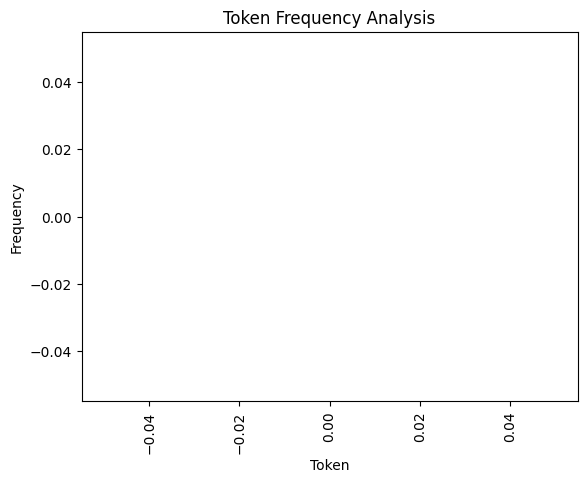

In [33]:
token_counts = get_token_counts(data, remove_stop_words=False)

# Sort the tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 most common tokens and their counts
top_tokens = [t[0] for t in sorted_tokens[:20]]
top_counts = [t[1] for t in sorted_tokens[:20]]

# Create the bar plot
plt.bar(top_tokens, top_counts)
plt.xticks(rotation=90)
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Token Frequency Analysis')
plt.show()


In [35]:
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

# Define the function to get collocations
def get_collocations(data):
    # Tokenize the text and filter out stop words
    stop_words = set(nltk.corpus.stopwords.words('portuguese'))
    tokenized_text = [word.lower() for file_id, file_data in data.items() for word in file_data['text'].split() if word.lower() not in stop_words]

    # Create a bigram collocation finder
    bigram_measures = BigramAssocMeasures()
    bigram_finder = BigramCollocationFinder.from_words(tokenized_text)

    # Filter out low frequency bigrams and get the top 10 collocations
    bigram_finder.apply_freq_filter(5)
    top_collocations = bigram_finder.nbest(bigram_measures.pmi, 10)

    return top_collocations
get_collocations(data)

[('fossa', 'iliaca'),
 ('conselho', 'tutelar'),
 ('cruz', 'capibaribe'),
 ('fosfato', 'tricalcio'),
 ('ossos', 'longos'),
 ('santo', 'agostinho'),
 ('fosseta', 'sacral'),
 ('midia', 'gomes'),
 ('murmurio', 'vesicular'),
 ('receitas', 'arvs')]

In [36]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

def get_collocations(data):
    collocations = []
    for file_id, file_data in data.items():
        text = file_data['text']
        annotations = file_data['annotations']
        annotated_tokens = []
        for annotation in annotations:
            start = annotation['start']
            end = annotation['end']
            annotated_text = text[start:end]
            annotated_tokens += annotated_text.split()

        finder = BigramCollocationFinder.from_words(annotated_tokens)
        bigram_measures = BigramAssocMeasures()
        scored = finder.score_ngrams(bigram_measures.raw_freq)
        collocations += scored

    return collocations
get_collocations(data)

[]

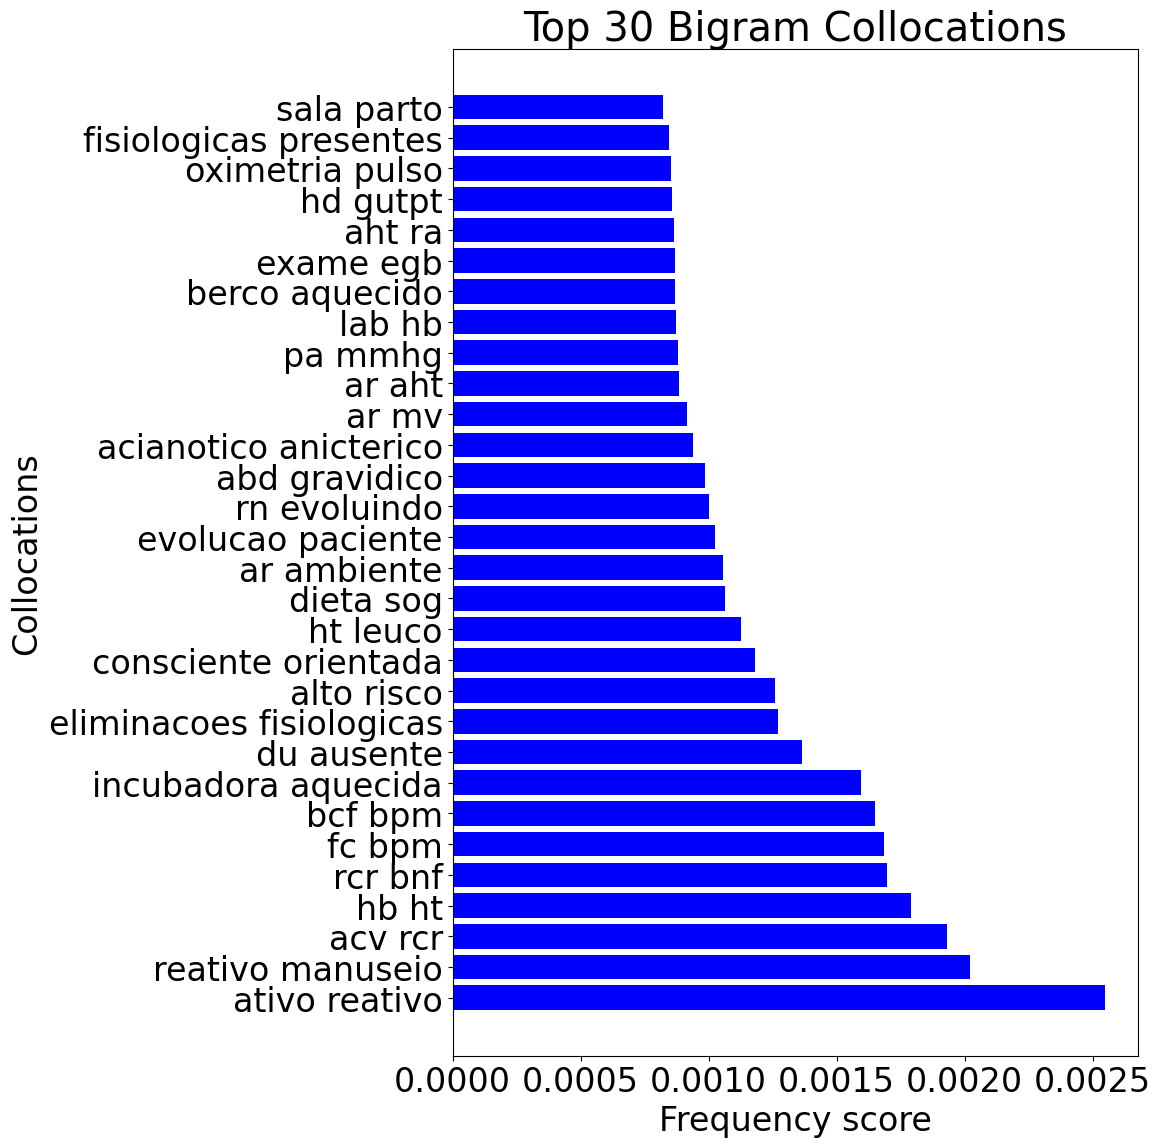

In [37]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('pt_core_news_sm')

# Load stop words
stop_words = set(nltk.corpus.stopwords.words('portuguese'))

all_tokens = []

for doc_id, doc in data.items():
    contents = doc['text']
    # tokenize the text
    tokens = nltk.word_tokenize(contents.lower())
    # remove stop words and punctuation
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    all_tokens.extend(tokens)

# create bigrams
bigrams = list(nltk.bigrams(all_tokens))
# create a bigram collocation finder
finder = BigramCollocationFinder.from_documents(bigrams)
# apply a scoring metric to rank the collocations
scored = finder.score_ngrams(BigramAssocMeasures().raw_freq)
# get the top 30 collocations
collocations = [' '.join(collocation) for collocation, score in scored[:30]]

# create a pandas dataframe with the collocations and their frequency
collocations_freq = [score for collocation, score in scored[:30]]
collocations = [' '.join(collocation) for collocation, score in scored[:30]]
df = pd.DataFrame({'collocation': collocations, 'frequency': collocations_freq})

# plot the collocations as a bar chart
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 24})
plt.barh(df['collocation'], df['frequency'], color='blue')
plt.title('Top 30 Bigram Collocations')
plt.ylabel('Collocations')
plt.xlabel('Frequency score')
plt.tight_layout()  # optional, to improve spacing

plt.show()

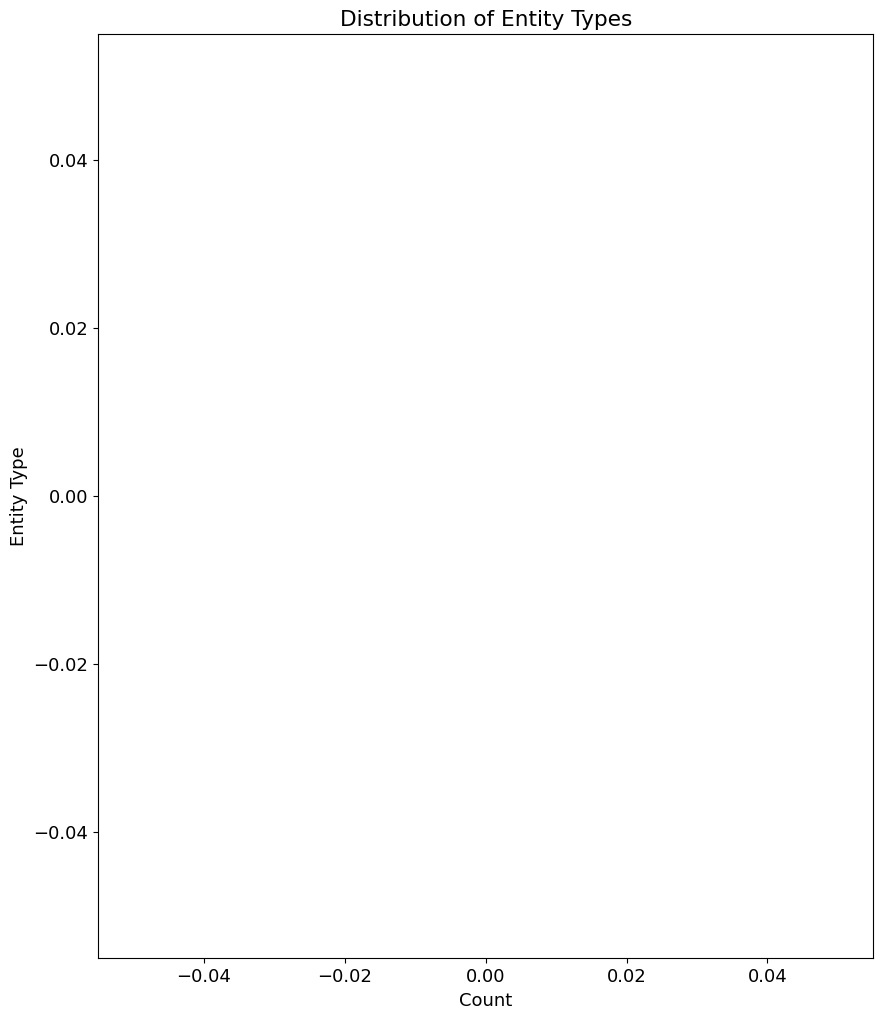

In [38]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt

# Load spaCy's English model
nlp = spacy.load('pt_core_news_sm', disable=['ner'])

# Create an empty dictionary to store entity types and their counts
entity_counts = {}

# Loop through each document in your data dictionary
for doc_id, doc in data.items():
    contents = doc['text']
    annotations = doc['annotations']

    # Create a Doc object from the text
    doc = nlp(contents)
    prev_end = -1
    # Add your custom annotations to the Doc object
    for ann in annotations:
        label = ann["label"]
        start = ann["start"]
        end = ann["end"]
        if start > prev_end:
            span = doc.char_span(start, end, label=label)
            if span is not None:
                doc.ents += tuple([span])
        prev_end = end
        
    # Loop through each entity in the parsed document
    for ent in doc.ents:
        # If the entity type is not in the entity_counts dictionary, add it with a count of 1
        if ent.label_ not in entity_counts:
            entity_counts[ent.label_] = 1
        # If the entity type is already in the entity_counts dictionary, increment its count by 1
        else:
            entity_counts[ent.label_] += 1        
            
# Convert the entity_counts dictionary to a pandas DataFrame for plotting
df = pd.DataFrame({'Entity Type': list(entity_counts.keys()), 'Count': list(entity_counts.values())})

# Sort the DataFrame by count in descending order
df = df.sort_values(by=['Count'], ascending=False)

# Plot the entity type counts as a bar chart
plt.rcParams.update({'font.size': 13})

plt.figure(figsize=(10, 12))
plt.barh(df['Entity Type'], df['Count'], color='blue')

plt.title('Distribution of Entity Types')
plt.ylabel('Entity Type')
plt.xlabel('Count')
plt.show()

In [41]:
# load the data
nlp = spacy.load('pt_core_news_sm', disable=['ner'])

# get the entity lengths
entity_lengths = []
for doc_id in data:
    for ann in data[doc_id]['annotations']:
        entity_lengths.append(ann['end'] - ann['start'])

# get the entity frequencies
entity_frequencies = Counter()
for doc_id in data:
    for ann in data[doc_id]['annotations']:
        entity_frequencies[ann['label']] += 1

# get the entity contexts
entity_contexts = {}
for doc_id in data:
    doc = nlp(data[doc_id]['text'])
    
    for ann in data[doc_id]['annotations']:
        label = ann["label"]
        start = ann["start"]
        end = ann["end"]
        if start > prev_end:
            span = doc.char_span(start, end, label=label)
            if span is not None:
                doc.ents += tuple([span])
        prev_end = end
    
    for ent in doc.ents:
        label = ent.label_
        start = ent.start_char
        end = ent.end_char
        context = doc[max(0, start-5):end+5].text
        if label not in entity_contexts:
            entity_contexts[label] = []
        entity_contexts[label].append(context)

# print the results
print('Entity lengths:')
print('  Min:', min(entity_lengths))
print('  Max:', max(entity_lengths))
print('  Mean:', sum(entity_lengths)/len(entity_lengths))
print('Entity frequencies:')
for label, freq in entity_frequencies.items():
    print('  {}: {}'.format(label, freq))

for label in entity_to_acronyms.keys():
    if not label in entity_frequencies.keys():
        print('  {}: {}'.format(label, 0))


print('Entity contexts:')
for label, contexts in entity_contexts.items():
    print('  {}:'.format(label))
    for context in contexts[:3]:
        if context:
            print('    - {}'.format(context))

Entity lengths:
  Min: 1
  Max: 19
  Mean: 5.187490383135867
Entity frequencies:
  Other_event: 57
  Subject: 326
  Therapeutic_procedure: 1626
  Severity: 182
  Sign_symptom: 2375
  Color: 297
  Frequency: 64
  Medication: 424
  Detailed_description: 1077
  Medical_team: 137
  Clinical_event: 417
  Time: 445
  Qualitative_concept: 19
  History: 92
  Administration: 291
  Biological_structure: 123
  Biological_attribute: 604
  Diagnostic_procedure: 1777
  Lab_value: 1510
  Nonbiological_location: 40
  Volume: 39
  Disease_disorder: 296
  Pregnancy_history: 37
  Pregnancy: 64
  Date: 184
  Height: 35
  Weight: 67
  Other_entity: 16
  Dosage: 104
  Quantitative_concept: 66
  Area: 5
  Age: 117
  Sex: 12
  Family_history: 27
  Outcome: 12
  Distance: 11
  Duration: 12
  Activity: 8
  Personal_background: 3
  Coreference: 0
  Mass: 0
  Occupation: 0
  Shape: 0
  Texture: 0
Entity contexts:
  Subject:
    - em ar ambiente acianotico anicterico com dieta por sog de 3/3hs para
    - hoje), ap

In [42]:
multi_label_words_count = 0
multi_label_files_count = 0
for file_id in data:
    annotations = data[file_id]['annotations']
    overlapping = False

    for i in range(len(annotations)-1):
        if annotations[i]['end'] >= annotations[i+1]['start']:
            overlapping = True
            multi_label_words_count += 1
            # print(f"Overlap found between {annotations[i]} and {annotations[i+1]}")

    if overlapping:
        multi_label_files_count += 1
        
print(f"Total number of words with multi labels found is {multi_label_words_count}")
print(f"Total number of files with multi labelled words is {multi_label_files_count}")

Total number of words with multi labels found is 25
Total number of files with multi labelled words is 15


In [43]:
total_count = 0
overlapping_count_dict = {}
for doc_id in data:

    overlapping_count = 0
    
    text = data[doc_id]['text']
    
    annotations = data[doc_id]['annotations']
    
    for i in range(len(annotations)-1):
        label = annotations[i]['label']
        start = annotations[i]['start']
        end = annotations[i]['end']
        
        if annotations[i]['end'] > annotations[i+1]['start']:
            total_count += 1
            overlapping_count += 1
    overlapping_count_dict[doc_id] = overlapping_count

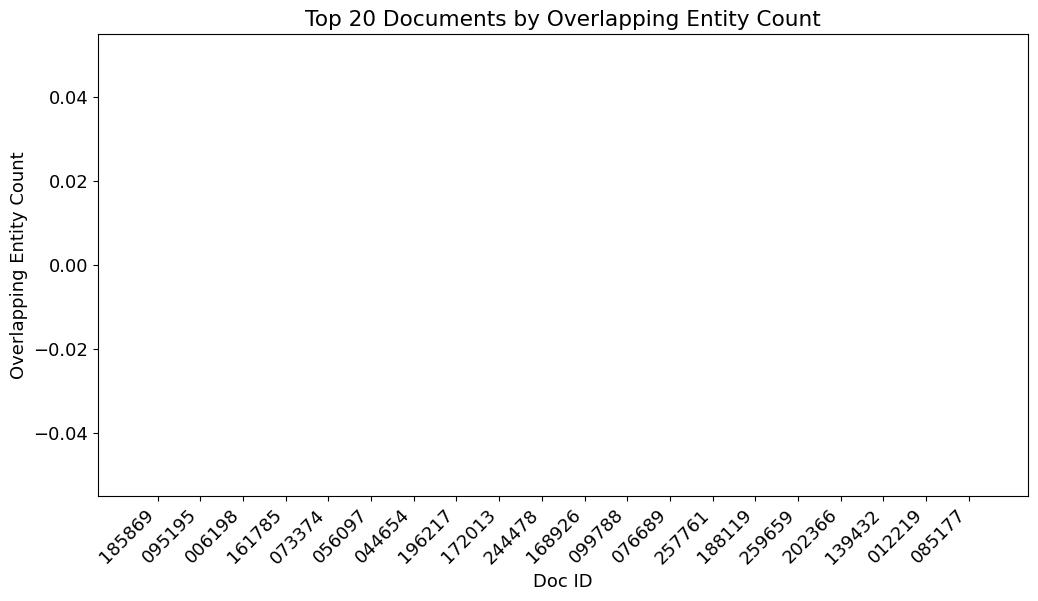

In [44]:
import matplotlib.pyplot as plt

sorted_dict = dict(sorted(overlapping_count_dict.items(), key=lambda item: item[1], reverse=True)[:20])
doc_ids = list(sorted_dict.keys())
overlapping_counts = list(sorted_dict.values())

fig, ax = plt.subplots(figsize=(12,6))


ax.set_xlabel('Doc ID')
ax.set_ylabel('Overlapping Entity Count')
ax.set_title('Top 20 Documents by Overlapping Entity Count')
ax.set_xticks(range(len(doc_ids)))  # set the tick locations
ax.set_xticklabels(doc_ids, rotation=45, ha='right')  # set the tick labels
ax.bar(doc_ids, overlapping_counts)
plt.show()


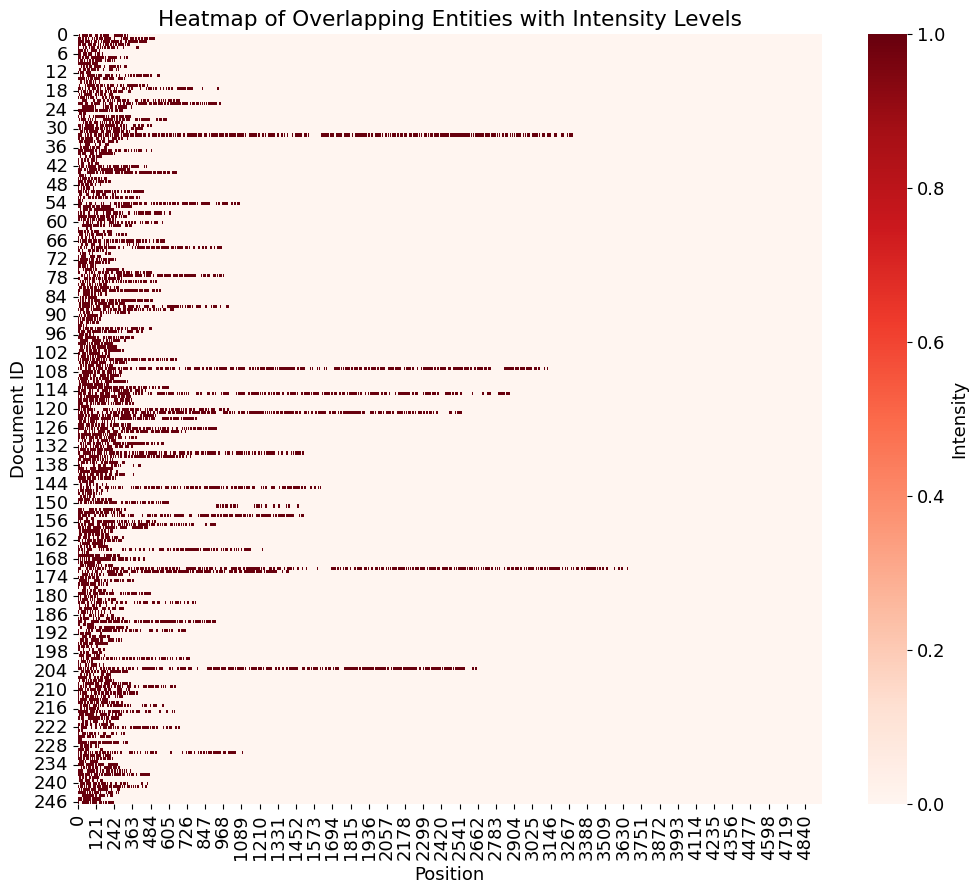

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# create the entity_ranges dictionary
entity_ranges = {}
max_end_of_text = 0

for doc_id in data:
    text = data[doc_id]['text']
    if len(text) > max_end_of_text:
        max_end_of_text = len(text)
        
    annotations = data[doc_id]['annotations']
    doc_entity_ranges = []
    for ann in annotations:
        start = ann['start']
        end = ann['end']
        doc_entity_ranges.append((start, end))
    entity_ranges[doc_id] = doc_entity_ranges

# create the heatmap with overlapping intensity levels
heatmap = np.zeros((len(entity_ranges), max_end_of_text))
row = 0
for doc_id, doc_entity_ranges in entity_ranges.items():
    for start, end in doc_entity_ranges:
        for i in range(start, end):
            heatmap[row][i] += 1
    row += 1
# plot the heatmap with Seaborn
plt.figure(figsize=(12, 10))
ax = sns.heatmap(heatmap, cmap='Reds', cbar_kws={'label': 'Intensity'})
ax.set_xlabel('Position')
ax.set_ylabel('Document ID')
ax.set_title('Heatmap of Overlapping Entities with Intensity Levels')

plt.show()

In [46]:
for file_id in data:
    annotations = data[file_id]['annotations']
    overlapping = False

    for i in range(len(annotations)-1):
        if annotations[i]['end'] > annotations[i+1]['start']:
            overlapping = True
            word_1 = data[file_id]['text'][annotations[i]['start']:annotations[i]['end']]
            word_2 = data[file_id]['text'][annotations[i+1]['start']:annotations[i+1]['end']]

            if word_1 != word_2:
                print(f"part of words overlaps: {word_1} {word_2}")
#                 print(f"labels: {file_id} {annotations[i]['label']} {annotations[i]['start']} {annotations[i]['end']}, {annotations[i+1]['label']} {annotations[i+1]['start']} {annotations[i+1]['end']}")

In [47]:
# Count number of files starting and ending with punctuation
start_punct_count = 0
end_punct_count = 0
neither_punct_count = 0

# Loop through each file in the data dictionary
for file_id, file_data in data.items():

    for annotation in file_data['annotations']:
        
        # Get the annotated text
        annotated_text = file_data['text'][annotation['start']:annotation['end']]
        # Check if the first or last character of the annotated text is a punctuation character
        if annotated_text[0] in string.punctuation:
            start_punct_count += 1
        elif annotated_text[-1] in string.punctuation:
            end_punct_count += 1
        else:
            neither_punct_count += 1
            
# Print counts in table format
print('{:<25}{}'.format('Category', 'Count'))
print('-'*35)
print('{:<25}{}'.format('Starts with punctuation', start_punct_count))
print('{:<25}{}'.format('Ends with punctuation', end_punct_count))
print('{:<25}{}'.format('Neither', neither_punct_count))

Category                 Count
-----------------------------------
Starts with punctuation  83
Ends with punctuation    226
Neither                  12689


In [48]:
def remove_trailing_punctuation(token):
    """
    Removes trailing punctuation from a token.

    Args:
        token (str): A string representing the token to be cleaned.

    Returns:
        str: The cleaned token with trailing punctuation removed.
    """
    while token and re.search(r'[^\w\s\']', token[-1]):
        token = token[:-1]
        
    return token

In [49]:
for file_id in data:
    annotations = data[file_id]['annotations']
    overlapping = False

    for i in range(len(annotations)-1):
        if annotations[i]['end'] > annotations[i+1]['start']:
            overlapping = True
            word_1 = data[file_id]['text'][annotations[i]['start']:annotations[i]['end']]
            word_2 = data[file_id]['text'][annotations[i+1]['start']:annotations[i+1]['end']]

            if remove_trailing_punctuation(word_1) != remove_trailing_punctuation(word_2):
                print(f"doc_id: {file_id} words: {word_1} {word_2}", end=" | ")
                print(f"labels: {file_id} {annotations[i]['label']} {annotations[i]['start']} {annotations[i]['end']}, {annotations[i+1]['label']} {annotations[i+1]['start']} {annotations[i+1]['end']}")

In [50]:
def create_json(preprocessed_data_dir, data):

    if os.path.exists(preprocessed_data_dir):
        # Delete the contents of the directory
        shutil.rmtree(preprocessed_data_dir)
    # Recreate the directory
    os.makedirs(preprocessed_data_dir)
    
    # Write the dictionary to a JSON file
    with open(os.path.join(preprocessed_data_dir, "annotated_data.json"), "w") as f:
        json.dump(data, f)

In [51]:
preprocessed_data_dir = "../data/annotated_json_data"
if not os.path.exists(preprocessed_data_dir):
    os.makedirs(preprocessed_data_dir,  exist_ok=True, mode=0o777)
create_json(preprocessed_data_dir, data)